In [ ]:
!pip install seaborn

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#imports
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import wordcloud
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.corpus import stopwords
import string

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from collections import Counter
from collections import defaultdict
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [ ]:
#Reading Data
df_train = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
df_test = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')

### **Basic Analysis**

In [ ]:
#shape
print('train_shape',df_train.shape)
print('test_shape',df_test.shape)

#null check
print(set(df_train.isnull().sum()))
print(set(df_test.isnull().sum()))

#duplicates check
print(df_train.shape[0]-df_train.drop_duplicates().shape[0])
print(df_test.shape[0]-df_test.drop_duplicates().shape[0])

In [ ]:
df_train.head()

In [ ]:
df_test.head()

In [ ]:
# class balance check
pos = df_train[df_train.target==1].shape[0]
neg = df_train[df_train.target==0].shape[0]
print('Positives',pos)
print('Negatives',neg)
print('P:N',np.round(pos*100/neg,2))

In [ ]:
# ## cerating new columns, 

# #length of question_test
# df_train['text_len'] = df_train['question_text'].apply(lambda x: len(x))


# # punctuations count
# def punc_count(x):
#     punc_lst = list(string.punctuation)
#     rtn = [p for p in punc_lst if p in x]
#     return len(rtn)
# df_train['punctuation_count'] = df_train['question_text'].apply(lambda x: punc_count(x))


# # stop words count
# def stopwords_count(x):
#     stopwords_lst = list(stopwords.words('english'))
#     rtn = [s for s in stopwords_lst if s in x]
#     return len(rtn)
# df_train['stopwords_count'] = df_train['question_text'].apply(lambda x: stopwords_count(x))

# # urls
# def url_count(x):
#     rtn = [u for u in x.split(' ') if 'http' in u]
#     return len(rtn)
# df_train['url_count'] = df_train['question_text'].apply(lambda x: url_count(x))


# #positive and negative reviews
# df_train_pos = df_train[df_train.target==1]
# df_train_neg = df_train[df_train.target==0]


# #plots
# fig,axes = plt.subplots(1,3,figsize=(12,5))

# sns.distplot(df_train_pos.text_len,ax=axes[0]).set_title('text length')
# sns.distplot(df_train_neg.text_len,ax=axes[0]).set_title('text length')

# sns.distplot(df_train_pos.punctuation_count,ax=axes[1]).set_title('Punctuation Count')
# sns.distplot(df_train_neg.punctuation_count,ax=axes[1]).set_title('Punctuation Count')

# sns.distplot(df_train_pos.stopwords_count,ax=axes[2]).set_title('Stopwords Count')
# sns.distplot(df_train_neg.stopwords_count,ax=axes[2]).set_title('Stopwords Count')

# plt.show()

In [ ]:
#positive and negative reviews
df_train_pos = df_train[df_train.target==1]
df_train_neg = df_train[df_train.target==0]

### **Meta features Creation**
Based on this SRK's EDA [kernal](https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author), creating following meta-features:-
1. Length of test
2. Number of words in the text
3. Number of unique words in the text
4. Number of characters in the text
5. Number of stopwords
6. Number of punctuations
7. Number of upper case words
8. Number of title case words
9. Number of numericals in the text
10. Average length of the words
11. Check for urls

The idea behind creating above features is to check if it helps in identifing distinction b/w negatives and positives

In [ ]:
# random 10 negative questions
_lst = list(df_train_pos['question_text'].sample(10))
for x in _lst:
    print(x)

In [ ]:
# random 10 positive questions
_lst = list(df_train_neg['question_text'].sample(10))
for x in _lst:
    print(x)

In [ ]:
class metaFeatures:
    
    def __init__(self,df):
        self.df = df
    
    #Number of words in the text
    @staticmethod
    def num_of_words(ech_row):
        rtn = len(ech_row.split())
        return rtn
    
    #Number of unique words in the text
    @staticmethod
    def num_of_unqwords(ech_row):
        rtn = len(set(ech_row.split()))
        return rtn
    
    #Number of characters in the text
    @staticmethod
    def num_of_chars(ech_row):
        rtn = len(set(ech_row))
        return rtn
    
    #Number of stopwords
    @staticmethod
    def num_of_stopwords(ech_row):
        stopwords_lst = list(stopwords.words('english'))
        rtn = len([s for s in str(ech_row).lower().split() if s in stopwords_lst])
        return rtn
    
    #Number of punctuations
    @staticmethod
    def num_of_punctuations(ech_row):
        punc_lst = list(string.punctuation)
        rtn = len([p for p in str(ech_row).lower().split() if p in punc_lst])
        return rtn
    
    #Number of upper case words
    @staticmethod
    def num_of_uppercase(ech_row):
        rtn = len([p for p in str(ech_row).split() if p.isupper()])
        return rtn
    
    #Number of title case words
    @staticmethod
    def num_of_titlecase(ech_row):
        rtn = len([p for p in str(ech_row).split() if p.istitle()])
        return rtn
    
    #Number of numericals in the text
    @staticmethod
    def num_of_numericals(ech_row):
        numer_lst = ['0','1','2','3','4','5','6','7','8','9']
        rtn = len([p for p in numer_lst if p in ech_row])
        return rtn
    
    #Average length of the words
    @staticmethod
    def words_avglen(ech_row):
        rtn = np.round( np.mean([len(p) for p in str(ech_row).split()]) ,2)
        return rtn
    
    # URLs Check
    @staticmethod
    def urls_count(ech_row):
        rtn = len([h for h in str(ech_row).lower().split() if 'http' in h or 'https' in h])
        return rtn
    
    #final calculations
    def calc(self):
        
        self.df['text_len'] = self.df['question_text'].apply(lambda x: len(x))
        self.df['num_of_words'] = self.df['question_text'].apply(lambda x: self.num_of_words(x))
        self.df['num_of_unqwords'] = self.df['question_text'].apply(lambda x: self.num_of_unqwords(x))
        self.df['num_of_chars'] = self.df['question_text'].apply(lambda x: self.num_of_chars(x))
        self.df['num_of_stopwords'] = self.df['question_text'].apply(lambda x: self.num_of_stopwords(x))
        self.df['num_of_punctuations'] = self.df['question_text'].apply(lambda x: self.num_of_punctuations(x))
        self.df['num_of_uppercase'] = self.df['question_text'].apply(lambda x: self.num_of_uppercase(x))
        self.df['num_of_titlecase'] = self.df['question_text'].apply(lambda x: self.num_of_titlecase(x))
        self.df['num_of_numericals'] = self.df['question_text'].apply(lambda x: self.num_of_numericals(x))
        self.df['words_avglen'] = self.df['question_text'].apply(lambda x: self.words_avglen(x))
        self.df['urls_count'] = self.df['question_text'].apply(lambda x: self.urls_count(x))
        
        return self.df

metafeatures = metaFeatures(df_train)
df_train_feat = metafeatures.calc()

#positive and negative reviews
df_train_pos = df_train_feat[df_train_feat.target==1]
df_train_neg = df_train_feat[df_train_feat.target==0]

df_train_feat.head()

In [ ]:
plot_cols = ['text_len', 'num_of_words', 'num_of_unqwords', 'num_of_chars',
             'num_of_stopwords', 'num_of_punctuations', 'num_of_uppercase',
             'num_of_titlecase', 'num_of_numericals', 'words_avglen','urls_count']

#plots
fig,axes = plt.subplots(6,2,figsize=(14,20),constrained_layout=True)
for k in range(0,len(plot_cols)):
    j = 0 if k%2==0 else 1
    i = k//2
    col = plot_cols[k]
    df = df_train_feat
    sns.boxplot(x='target', y=col, data=df, ax=axes[i,j])

fig.delaxes(axes[5,1])
plt.show()

In [ ]:
plot_cols = ['text_len', 'num_of_words', 'num_of_unqwords', 'num_of_chars',
             'num_of_stopwords', 'num_of_punctuations', 'num_of_uppercase',
             'num_of_titlecase', 'num_of_numericals', 'words_avglen','urls_count']

#plots
fig,axes = plt.subplots(6,2,figsize=(14,20),constrained_layout=True)

for k in range(0,len(plot_cols)):
    j = 0 if k%2==0 else 1
    i = k//2
    col = plot_cols[k]
    sns.violinplot(x='target', y=col, data=df_train_feat, ax=axes[i,j])

fig.delaxes(axes[5,1])
plt.show()

In [ ]:
# plot_cols = ['text_len', 'num_of_words', 'num_of_unqwords', 'num_of_chars',
#              'num_of_stopwords', 'num_of_punctuations', 'num_of_uppercase',
#              'num_of_titlecase', 'num_of_numericals', 'words_avglen','urls_count']

# #plots
# fig,axes = plt.subplots(6,2,figsize=(14,20),constrained_layout=True)

# for k in range(0,len(plot_cols)):
#     j = 0 if k%2==0 else 1
#     i = k//2
#     col = plot_cols[k]
#     val_0 = df_train_feat[df_train_feat.target==0][col]
#     val_1 = df_train_feat[df_train_feat.target==1][col]
#     val_all = df_train_feat[col]
    
#     #sns.distplot(val_0,kde=False,color='red', ax=axes[i,j])
#     #sns.distplot(val_1,kde=False,color='blue', ax=axes[i,j])
#     sns.distplot(val_all,kde=False,color='green', ax=axes[i,j])

# fig.delaxes(axes[5,1])
# plt.show()

### **Inference:-**
1. length of question(`text_len`) gives some minor distinction b/w positivies and negatives
2. `num_of_words` and `num_of_unqwords` have similar distribution as that of `text_len`, this is logical as text length increases `num_of_words` and `num_of_unqwords` also increase
3. `num_of_stopwords` has interesting distribution

As length of text has some role lets look at frequency of words... `Word Cloud`

some of below functions are refered from this [kernal](https://www.kaggle.com/colearninglounge/nlp-end-to-end-cll-nlp-workshop)

In [ ]:
#WordCloud Visualizations
#Method for creating wordclouds
from PIL import Image
def display_cloud(data,color):
    plt.subplots(figsize=(15,15))
    mask = None
    wc = WordCloud(stopwords=STOPWORDS, 
                   mask=mask, background_color="white", contour_width=2, contour_color=color,
                   max_words=2000, max_font_size=256,
                   random_state=42)
    wc.generate(' '.join(data))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    
# good and bad questions--using this terminology from now on
df_train_bad = df_train_feat[df_train_feat.target==1]
df_train_good = df_train_feat[df_train_feat.target==0]

In [ ]:
display_cloud(df_train_bad['question_text'],'red')

In [ ]:
display_cloud(df_train_good['question_text'],'red')

Looks interesting, here good questions have words describing <u>actions</u>, where as bad questions have words used for some kind of <u>description</u>

### N-Gram Analysis

In [ ]:
stopword=set(stopwords.words('english'))
def generate_grams(txt,n_gram):
    tokens = [t for t in txt.lower().split() if t != "" if t not in stopword]
    ngrams = zip(*[tokens[i:] for i in range(n_gram)])
    final_tokens=[" ".join(z) for z in ngrams]
    return final_tokens

def calculate_frequency(df_series,n_gram):
    dict_rtn = defaultdict(int)
    for txt in df_series:
        for _key in generate_grams(txt,n_gram):
            dict_rtn[_key] += 1
    
    sort_dict = sorted(dict_rtn.items(),key=lambda itm:itm[1],reverse=True)
    df_rtn = pd.DataFrame(sort_dict, columns=['n_gram_words', 'n_gram_frequency'])
    return df_rtn

def plotly_bar_chart(df,color):
    trace = go.Bar(
        y=df["n_gram_words"].values[::-1],
        x=df["n_gram_frequency"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

def final_plots(df,n_gram=1,top=20):
    freq_df_0 = calculate_frequency(df[df.target==0]['question_text'],n_gram)
    trace_0=plotly_bar_chart(freq_df_0[:top],'orange')
    
    freq_df_1 = calculate_frequency(df[df.target==1]['question_text'],n_gram)
    trace_1=plotly_bar_chart(freq_df_1[:top],'orange')
    
    fig = make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of good questions", 
                                          "Frequent words of bad questions"])
    fig.append_trace(trace_0, 1, 1)
    fig.append_trace(trace_1, 1, 2)
    fig['layout'].update(height=1200, width=1000, paper_bgcolor='rgb(233,233,233)', title=f"Word Count(ngrams={n_gram}) Plots")
    py.iplot(fig, filename='word-plots')

In [ ]:
print('Uni-Gram')
final_plots(df_train_feat,n_gram=1,top=10)

In [ ]:
print('Bi-Gram')
final_plots(df_train_feat,n_gram=2,top=10)

In [ ]:
print('Tri-Gram')
final_plots(df_train_feat,n_gram=3,top=10)

In [ ]:
print('Tetra-Gram')
final_plots(df_train_feat,n_gram=4,top=10)

## Data Cleaning

In [ ]:
class CleanIt:
    
    def __init__(self,df):
        self.df = df
    
    #Removes Punctuations
    @staticmethod
    def remove_punctuations(ech_row):
        punct_tag = re.compile(r'[^\w\s]')
        rtn = punct_tag.sub(r'',ech_row)
        return rtn
    
    #Removes HTML syntaxes
    @staticmethod
    def remove_html(ech_row):
        html_tag=re.compile(r'<.*?>')
        rtn=html_tag.sub(r'',ech_row)
        return rtn
    
    #Removes URL data
    @staticmethod
    def remove_url(ech_row):
        url_clean= re.compile(r"https://\S+|www\.\S+")
        rtn=url_clean.sub(r'',ech_row)
        return rtn
    
    #Removes Emojis
    @staticmethod
    def remove_emoji(ech_row):
        emoji_clean= re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        rtn=emoji_clean.sub(r'',ech_row)
        url_clean= re.compile(r"https://\S+|www\.\S+")
        rtn=url_clean.sub(r'',rtn)
        return rtn
    
    #Lower Case
    @staticmethod
    def make_it_lower(ech_row):
        rtn=ech_row.lower()
        return rtn
    
    #Remove extra spaces
    @staticmethod
    def remove_extraSpace(ech_row):
        rtn=' '.join(ech_row.split())
        return rtn
    
    #Replace abbreviated pronouns with full forms
    @staticmethod
    def remove_abb(data):
        data = re.sub(r"he's", "he is", data)
        data = re.sub(r"there's", "there is", data)
        data = re.sub(r"We're", "We are", data)
        data = re.sub(r"That's", "That is", data)
        data = re.sub(r"won't", "will not", data)
        data = re.sub(r"they're", "they are", data)
        data = re.sub(r"Can't", "Cannot", data)
        data = re.sub(r"wasn't", "was not", data)
        data = re.sub(r"don\x89Ûªt", "do not", data)
        data= re.sub(r"aren't", "are not", data)
        data = re.sub(r"isn't", "is not", data)
        data = re.sub(r"What's", "What is", data)
        data = re.sub(r"haven't", "have not", data)
        data = re.sub(r"hasn't", "has not", data)
        data = re.sub(r"There's", "There is", data)
        data = re.sub(r"He's", "He is", data)
        data = re.sub(r"It's", "It is", data)
        data = re.sub(r"You're", "You are", data)
        data = re.sub(r"I'M", "I am", data)
        data = re.sub(r"shouldn't", "should not", data)
        data = re.sub(r"wouldn't", "would not", data)
        data = re.sub(r"i'm", "I am", data)
        data = re.sub(r"I\x89Ûªm", "I am", data)
        data = re.sub(r"I'm", "I am", data)
        data = re.sub(r"Isn't", "is not", data)
        data = re.sub(r"Here's", "Here is", data)
        data = re.sub(r"you've", "you have", data)
        data = re.sub(r"you\x89Ûªve", "you have", data)
        data = re.sub(r"we're", "we are", data)
        data = re.sub(r"what's", "what is", data)
        data = re.sub(r"couldn't", "could not", data)
        data = re.sub(r"we've", "we have", data)
        data = re.sub(r"it\x89Ûªs", "it is", data)
        data = re.sub(r"doesn\x89Ûªt", "does not", data)
        data = re.sub(r"It\x89Ûªs", "It is", data)
        data = re.sub(r"Here\x89Ûªs", "Here is", data)
        data = re.sub(r"who's", "who is", data)
        data = re.sub(r"I\x89Ûªve", "I have", data)
        data = re.sub(r"y'all", "you all", data)
        data = re.sub(r"can\x89Ûªt", "cannot", data)
        data = re.sub(r"would've", "would have", data)
        data = re.sub(r"it'll", "it will", data)
        data = re.sub(r"we'll", "we will", data)
        data = re.sub(r"wouldn\x89Ûªt", "would not", data)
        data = re.sub(r"We've", "We have", data)
        data = re.sub(r"he'll", "he will", data)
        data = re.sub(r"Y'all", "You all", data)
        data = re.sub(r"Weren't", "Were not", data)
        data = re.sub(r"Didn't", "Did not", data)
        data = re.sub(r"they'll", "they will", data)
        data = re.sub(r"they'd", "they would", data)
        data = re.sub(r"DON'T", "DO NOT", data)
        data = re.sub(r"That\x89Ûªs", "That is", data)
        data = re.sub(r"they've", "they have", data)
        data = re.sub(r"i'd", "I would", data)
        data = re.sub(r"should've", "should have", data)
        data = re.sub(r"You\x89Ûªre", "You are", data)
        data = re.sub(r"where's", "where is", data)
        data = re.sub(r"Don\x89Ûªt", "Do not", data)
        data = re.sub(r"we'd", "we would", data)
        data = re.sub(r"i'll", "I will", data)
        data = re.sub(r"weren't", "were not", data)
        data = re.sub(r"They're", "They are", data)
        data = re.sub(r"Can\x89Ûªt", "Cannot", data)
        data = re.sub(r"you\x89Ûªll", "you will", data)
        data = re.sub(r"I\x89Ûªd", "I would", data)
        data = re.sub(r"let's", "let us", data)
        data = re.sub(r"it's", "it is", data)
        data = re.sub(r"can't", "cannot", data)
        data = re.sub(r"dont", "do not", data)
        data = re.sub(r"don't", "do not", data)
        data = re.sub(r"you're", "you are", data)
        data = re.sub(r"i've", "I have", data)
        data = re.sub(r"that's", "that is", data)
        data = re.sub(r"i'll", "I will", data)
        data = re.sub(r"doesn't", "does not",data)
        data = re.sub(r"i'd", "I would", data)
        data = re.sub(r"didn't", "did not", data)
        data = re.sub(r"ain't", "am not", data)
        data = re.sub(r"you'll", "you will", data)
        data = re.sub(r"I've", "I have", data)
        data = re.sub(r"Don't", "do not", data)
        data = re.sub(r"I'll", "I will", data)
        data = re.sub(r"I'd", "I would", data)
        data = re.sub(r"Let's", "Let us", data)
        data = re.sub(r"you'd", "You would", data)
        data = re.sub(r"It's", "It is", data)
        data = re.sub(r"Ain't", "am not", data)
        data = re.sub(r"Haven't", "Have not", data)
        data = re.sub(r"Could've", "Could have", data)
        data = re.sub(r"youve", "you have", data)  
        data = re.sub(r"donå«t", "do not", data)
        return data

    #final calculations
    def calc(self):
        self.df['question_text'] = self.df['question_text'].apply(lambda x: self.remove_extraSpace(x))
        
        self.df['question_text'] = self.df['question_text'].apply(lambda x: self.remove_punctuations(x))
        self.df['question_text'] = self.df['question_text'].apply(lambda x: self.remove_html(x))
        self.df['question_text'] = self.df['question_text'].apply(lambda x: self.remove_url(x))
        self.df['question_text'] = self.df['question_text'].apply(lambda x: self.remove_emoji(x))
        self.df['question_text'] = self.df['question_text'].apply(lambda x: self.remove_abb(x))
        
        self.df['question_text'] = self.df['question_text'].apply(lambda x: self.make_it_lower(x))
        return self.df

import re
data_clean = CleanIt(df_train)
df_train_clean_feat = data_clean.calc()

#positive and negative reviews
df_train_clean_pos = df_train_clean_feat[df_train_clean_feat.target==1]
df_train_clean_neg = df_train_clean_feat[df_train_clean_feat.target==0]

df_train_clean_feat.head()

In [ ]:
#WordCloud Visualizations
#Method for creating wordclouds
from PIL import Image
def display_cloud(data,color):
    plt.subplots(figsize=(15,15))
    mask = None
    wc = WordCloud(stopwords=STOPWORDS, 
                   mask=mask, background_color="white", contour_width=2, contour_color=color,
                   max_words=2000, max_font_size=256,
                   random_state=42)
    wc.generate(' '.join(data))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    
# good and bad questions--using this terminology from now on
df_train_clean_bad = df_train_clean_feat[df_train_clean_feat.target==1]
df_train_clean_good = df_train_clean_feat[df_train_clean_feat.target==0]

In [ ]:
display_cloud(df_train_clean_bad['question_text'],'red')

In [ ]:
display_cloud(df_train_clean_good['question_text'],'red')

In [ ]:
print('Uni-Gram')
final_plots(df_train_clean_feat,n_gram=1,top=10)

In [ ]:
print('Tri-Gram')
final_plots(df_train_clean_feat,n_gram=3,top=10)

In [ ]:
print('Tetra-Gram')
final_plots(df_train_clean_feat,n_gram=4,top=10)

**Stemming :** This is the final and most important part of the preprocessing. stemming converts words to its stem.
For example playing and played are the same type of words which basically indicate an action play. Stemmer does exactly this, it reduces the word to its stem. we are going to use a library called porter-stemmer which is a rule based stemmer. Porter-Stemmer identifies and removes the suffix or affix of a word. The words given by the stemmer need note be meaningful few times<br>

**Lemmatisation :** is a way to reduce the word to root synonym of a word. Unlike Stemming, Lemmatisation makes sure that the reduced word is again a dictionary word (word present in the same language). WordNetLemmatizer can be used to lemmatize any word.
<br><br>
**Stemming vs Lemmatization**
* Stemming — need not be a dictionary word, removes prefix and affix based on few rules
* Lemmatization — will be a dictionary word. reduces to a root synonym.

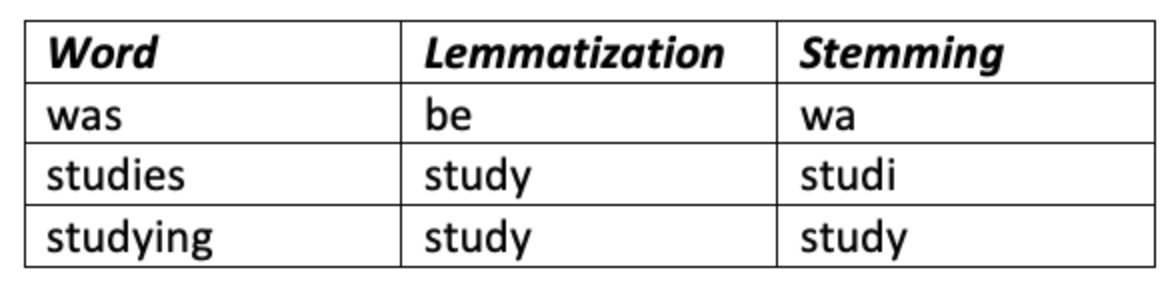

Source: https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
import spacy
spacy_mdl = spacy.load('en_core_web_sm')

In [ ]:
#Lemmatize the dataset
def lemma_traincorpus(data):
    lemmatizer=WordNetLemmatizer()
    out_data=""
    for words in data:
        out_data+= lemmatizer.lemmatize(words)
    return out_data

df_train_clean_feat['question_text']=df_train_clean_feat['question_text'].apply(lambda ech_row: lemma_traincorpus(ech_row))

_lst = list(df_train_clean_feat['question_text'].sample(10))
for x in _lst:
    print(x)

In [ ]:
# # #Lemmatize the dataset
# def lemma_traincorpus(data):
#     tokens = spacy_mdl(data)
#     lemma = []
#     for words in tokens:
#         lemma.append(words.lemma_)
#     rtn = (" ").join(lemma)
#     return rtn


# df_train_clean_feat['question_text_lemma']=df_train_clean_feat['question_text'].apply(lambda ech_row: lemma_traincorpus(ech_row))

# _lst = list(df_train_clean_feat['question_text_lemma'].sample(10))
# for x in _lst:
#     print(x)

In [ ]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

### **Vectorization - TFIDF and Count**

In [ ]:
%%time
tfidf_vect=TfidfVectorizer(stop_words='english',ngram_range=(1,3))
train_tfidf=tfidf_vect.fit_transform(df_train_clean_feat['question_text'].values.tolist())
train_tfidf.shape

In [ ]:
#print(train_tfidf)

In [ ]:
%%time
#Stratified Train Test Split

train_stratify_y=train_df['sentiment']
train_stratified_x,test_stratified_x,train_stratified_y,test_stratified_y=train_test_split(train_set,train_stratify_y,test_size=0.2,
                                                                                           random_state=42,stratify=train_stratify_y)
train_stratified_x.shape,train_stratified_y.shape,test_stratified_x.shape,test_stratified_y.shape

In [ ]:
class Run_models:
    #imports
    import numpy as np
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    import xgboost
    from imblearn.metrics import classification_report_imbalanced
    from sklearn.metrics import classification_report,roc_auc_score,roc_curve,r2_score,recall_score,confusion_matrix,precision_recall_curve
    from collections import Counter
    from sklearn.model_selection import StratifiedKFold,KFold,StratifiedShuffleSplit
    from xgboost import XGBClassifier
    from lightgbm import LGBMClassifier
    from sklearn.ensemble import RandomForestRegressor,GradientBoostingClassifier,RandomForestClassifier

    def __init__(self,train_x,train_y):
        self.train_x = train_x
        self.train_y = train_y
    
    def kFold(self,mdl):
        kfold=StratifiedKFold(n_splits=5,random_state=42)
        rtn=cross_val_score(model,self.train_x,self.train_y,cv=kfold,scoring='roc_auc')
        return rtn
        
    def logisticRegression(self):
        mdl = LogisticRegression(C=1.0,penalty='l2')
        rtn = self.kFold(mdl)
        return rtn
    
    
    def gradientBoost(self):
        mdl = GradientBoostClassifier(learning_rate=0.02, loss='deviance',n_estimators=50)
        rtn = self.kFold(mdl)
        return rtn
    
    def xgBoost(self):
        mdl = XGBClassifier(n_estimators=50,random_state=42)
        rtn = self.kFold(mdl)
        return rtn
                            
    def lightGBM(self):
        mdl = LGBMClassifier(n_estimators=50,random_state=42)
        rtn = self.kFold(mdl)
        return rtn
    
    def apply_all_models(self):
        cv_rtn = {}
        cv_rtn['LogisticRregression'] = self.logisticRegression()
        cv_rtn['gradientBoost'] = self.gradientBoost()
        cv_rtn['xgBoost'] = self.xgBoost()
        cv_rtn['lightGBM'] = self.lightGBM()
        
        rtn_dict = {}
        for k in cv_rtn.keys():
            m = np.round(np.mean(cv_rtn),3)
            l = cv_rtn[k]
            rtn_dict[k] = (m,l)
        return rtn_dict

models_all = Run_models(train_x,train_y)
ml_tfidf_result = models_all.apply_all_models()
print(ml_tfidf_result)